# Calculating dNBR for the Dixie Fire in Butte County, California, 2021

Import necessary libraries

In [117]:
from utils import *
import planetary_computer
import stackstac
import rioxarray as rxr
import xarray as xr
from rioxarray.merge import merge_datasets
import geopandas as gpd
import rasterio
import numpy as np

Dask cluster setup

In [2]:
from dask.distributed import Client as DaskClient, LocalCluster

# Set the total memory available (in GB)
total_memory = 8  # GB
workers = 2

# Calculate memory per worker
memory_per_worker = total_memory / workers

# Set up the Dask cluster with memory per worker
cluster = LocalCluster(
    n_workers=workers,  # Number of workers
    threads_per_worker=4,  # One thread per worker
    memory_limit=f"{memory_per_worker}GB"  # Set memory limit per worker
)

# Connect the client to the cluster
client = DaskClient(cluster)

# Check cluster status
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45099,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:41141,Total threads: 4
Dashboard: http://127.0.0.1:41337/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44535,


Initialize Pystac Client

In [28]:
from pystac_client import Client as PystacClient
api_url = "https://earth-search.aws.element84.com/v1"
stac_client = PystacClient.open(api_url)

Search for scenes that line up with the center of Butte county and are in the weeks leading up to and after the fire

In [29]:
point = dict(type="Point", coordinates=(-121.600741, 39.671238))

In [63]:
pre_datetime = "2021-07-13/2021-07-17"
post_datetime = "2021-10-26/2021-11-20"

In [64]:
pre = search_api(pre_datetime, point)

4


In [72]:
for item in pre:
    print(item.properties["eo:cloud_cover"])

0.014602
0.175295
0.016234
0.076742
<Item id=S2B_10TFK_20210713_0_L2A>


In [92]:
selected_pre_image = pre[3] 
selected_post_image = post[3]

In [93]:
assets_pre = selected_pre_image.assets
assets_post = selected_post_image.assets
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [100]:
#pram
nir_pre_href = assets_pre["nir08"].href
print(nir_pre_href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/B8A.tif


In [101]:
#param
swir_pre_href = assets_pre["swir16"].href
print(swir_pre_href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/B11.tif


In [106]:
nir = rxr.open_rasterio(nir_pre_href)
nir

<xarray.DataArray (band: 1, y: 5490, x: 5490)> Size: 60MB
[30140100 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 44kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

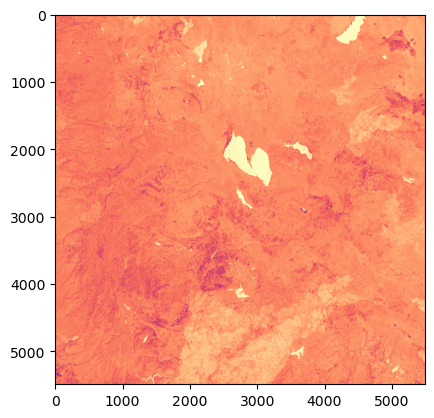

In [110]:
plt.imshow(nir[0,:,:], cmap="magma_r")

In [88]:
swir = rxr.open_rasterio(swir_pre_href)
swir

<xarray.DataArray (band: 1, y: 5490, x: 5490)> Size: 60MB
[30140100 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 44kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

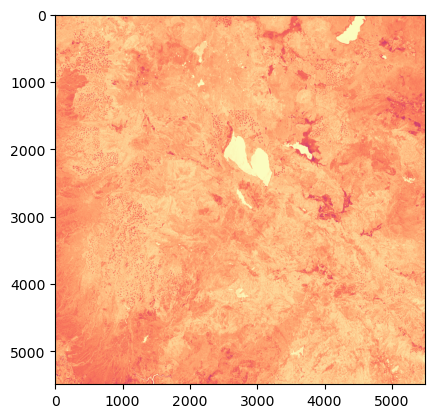

In [98]:
# Get a 2D slice of the image
plt.imshow(swir[0, :, :], cmap="magma_r")

In [94]:
print(type(swir)) 
print(swir.shape)

<class 'xarray.core.dataarray.DataArray'>
(1, 5490, 5490)


In [65]:
post = search_api(post_datetime, point)

4


In [69]:
for item in post: 
    print(item.properties["eo:cloud_cover"])

3.552187
1.28479
0.774149
0.363516


In [122]:
array = nir
stats = [] 
for band in array: 
    stats.append({'min': band, 'mean': band, 'median': np.median(band), 'max': band.max()}) #normalization

def normalize(array): 
    array_max = array.max() 
    return (array/array_max)

nir = nir / 10000

In [123]:
print("min value" , np.min(nir))
print("max value" , np.max(nir))

min value <xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    spatial_ref  int64 8B 0
max value <xarray.DataArray ()> Size: 8B
array(0.0009687)
Coordinates:
    spatial_ref  int64 8B 0


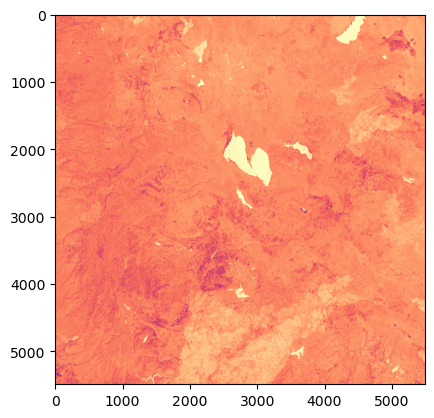

In [124]:
plt.imshow(nir[0, :, :], cmap="magma_r")

In [ ]:
NBR = ((nir - swir)/(nir + swir))

In [128]:
def gen_map(band1, band2, selected_pre_image, selected_post_image):
    assets_pre = selected_pre_image.assets
    assets_post = selected_post_image.assets
    
    nir_pre_href = assets_pre[band1].href
    print(nir_pre_href)

    swir_pre_href = assets_pre[band2].href
    print(swir_pre_href)

    nir = rxr.open_rasterio(nir_pre_href)
    
    plt.imshow(0,:,:], cmap="magma_r")
    plt.imshow(band2[0,:,:], cmap="magma_r")

gen_map("nir08", "swir16", selected_pre_image, selected_post_image)


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (318426290.py, line 13)